# Imports

##### General imports

In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("../")

In [2]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import copy
from tqdm import tqdm
import pprint

##### Import from flatland environment 

In [3]:
from flatland.envs.rail_env import RailEnv
from flatland.envs.observations import *
from flatland.envs.rail_generators import complex_rail_generator,rail_from_manual_specifications_generator,random_rail_generator, RailGenerator,sparse_rail_generator
from flatland.envs.schedule_generators import complex_schedule_generator, random_schedule_generator, ScheduleGenerator, sparse_schedule_generator
from flatland.utils.rendertools import RenderTool, AgentRenderVariant

##### Import from our framework

In [4]:
from src.graph import NetworkGraph

In [5]:
from src.flows import *

# Test of time expanded network

##### Create a flatland network

sparse netwrok

In [6]:
if False:
    number_agents = 5

    size_side = 50
    stochastic_data = {'prop_malfunction': 0.3,  # Percentage of defective agents
                       'malfunction_rate': 30,  # Rate of malfunction occurence
                       'min_duration': 3,  # Minimal duration of malfunction
                       'max_duration': 20  # Max duration of malfunction
                       }
    speed_ration_map = {1.: 0.25,  # Fast passenger train
                        1. / 2.: 0.25,  # Fast freight train
                        1. / 3.: 0.25,  # Slow commuter train
                        1. / 4.: 0.25}  # Slow freight train
    env = RailEnv(width=size_side,
                  height=size_side,
                  rail_generator=sparse_rail_generator(max_num_cities=4,
                                                       # Number of cities in map (where train stations are)
                                                       seed=14,  # Random seed
                                                       grid_mode=False,
                                                       max_rails_between_cities=2,
                                                       max_rails_in_city=8,
                                                       ),
                  schedule_generator=sparse_schedule_generator(speed_ration_map),
                  number_of_agents=number_agents,
                  stochastic_data=stochastic_data,  # Malfunction data generator
                  obs_builder_object=GlobalObsForRailEnv(),
                  remove_agents_at_target=True
                  )

    # RailEnv.DEPOT_POSITION = lambda agent, agent_handle : (agent_handle % env.height,0)
    env.reset()

    env_renderer = RenderTool(env,
                              agent_render_variant=AgentRenderVariant.AGENT_SHOWS_OPTIONS_AND_BOX,
                              show_debug=True,
                              screen_height=1100,
                              screen_width=1800)
    env_renderer.reset()

    env_renderer.render_env(show=True, show_observations=False, show_predictions=False)



usual network

In [7]:
number_agents = 10

size_side = 20
env = RailEnv(width=size_side,
              height=size_side,
              rail_generator=complex_rail_generator(nr_start_goal=number_agents, nr_extra=1, 
                                                    min_dist=6, max_dist=99999, 
                                                    seed = np.random.randint(0,2000)),
              schedule_generator=complex_schedule_generator(),
              number_of_agents=number_agents,
              obs_builder_object=GlobalObsForRailEnv())

env.reset()



env_renderer = RenderTool(env)
env_renderer.render_env(show=True, show_predictions=False, show_observations=False)

In [9]:
matrix_rail = np.array(env.rail.grid.tolist())

In [8]:
solver = Solver("test.log")

In [10]:
solver.solve(env,100)

10it [00:01,  9.61it/s]


iteration  1
certificat for ('source_3', 'sink_3'): weight is 41.0, sigma is 43.0
certificat for ('source_6', 'sink_6'): weight is 47.0, sigma is 53.0
 commodities with updated paths: dict_keys([3, 6])
iteration  2
certificat for ('source_1', 'sink_1'): weight is 23.0, sigma is 27.0
certificat for ('source_2', 'sink_2'): weight is 24.0, sigma is 25.0
certificat for ('source_3', 'sink_3'): weight is 42.0, sigma is 43.0
certificat for ('source_6', 'sink_6'): weight is 49.0, sigma is 53.0
 commodities with updated paths: dict_keys([1, 2, 3, 6])
iteration  3
certificat for ('source_1', 'sink_1'): weight is 22.0, sigma is 23.0
certificat for ('source_6', 'sink_6'): weight is 48.0, sigma is 49.0
 commodities with updated paths: dict_keys([1, 6])
iteration  4
score: 334.0


In [11]:
solver2 = Solver("test.log","Arc Formulation")
solver2.solve(env,100)

Setting up the arc formulation may take some time and RAM
no collision detected
score: 334.0


In [ ]:
sources = []
sinks = []
directions = []
for agent in env.agents:
    sources.append(agent.initial_position)
    sinks.append(agent.target)
    try:
        directions.append(agent.direction)
    except:
        pass

In [ ]:
if len(directions) == 0:
    directions = None

##### create a time expanded network

In [ ]:
import time

In [ ]:
start = time.time()
TestNetworkTime = TimeNetwork(flatlandNetwork, depth=200)
stop = time.time()
print(f'time taken to build the graph: {stop-start}')

In [ ]:
TestNetworkTime.connect_sources_and_sink(sources,sinks,directions = None)

### create initial solution

In [ ]:
from tqdm import tqdm

In [ ]:
constraints, find_constraints = TestNetworkTime.get_topology_network()

In [ ]:
test = InitialSolutionGenerator(TestNetworkTime,constraints,find_constraints,len(sources))

In [ ]:
solution = test.getInitialSolution()

In [ ]:
test.showStats()

In [ ]:
len(solution)

In [ ]:
cost = 0
for p in solution:
    cost += len(p)
    
print(cost)

In [ ]:
solver = Solver("./test.txt")

In [ ]:
solver.solve(env,200)

In [ ]:
from src.flows.PricingProblem import PricingSolver

In [ ]:
start = time.time()
flag = True
iteration = 1
master = MasterProblem.MasterProblem(solution,constraints,find_constraints,number_agents)
master.build()
pricingSolver = PricingSolver(TestNetworkTime.graph,constraints,find_constraints,len(sources))
while flag:
    print("iteration ",iteration)
    master.solveRelaxedModel()
    duals = master.getDualVariables()
    pathsToAdd, flag = pricingSolver.get_columns_to_add(master.getDualVariables(),master.constraintsActivated)
    if flag:
        #pprint.pprint(pathsToAdd)
        print(f" commodities with updated paths: {pathsToAdd.keys()}")
        iteration+= 1
        master.addColumn(pathsToAdd)
print(f"column generation method took {np.round(time.time()-start,3)} sec")

In [ ]:
master.relaxedModel.objVal

In [ ]:
master.model.optimize()

In [ ]:
master.model.objVal

In [ ]:
for v in master.relaxedModel.getVars():
    print('%s %g' % (v.varName, v.x))

In [ ]:
for v in master.model.getVars():
    print('%s %g' % (v.varName, v.x))

In [ ]:
master.cost

In [ ]:
master.model.write("temp/test.lp")

##### Test LP Formulation

test a simple graph

In [ ]:
import datetime as dt
print(dt.datetime.now())

In [ ]:
constraints,findConstraints = TestNetworkTime.get_topology_network()

In [ ]:
mcflow = MCFlow(TestNetworkTime.graph,len(sources),constraints,integer = True)

In [ ]:
mcflow.solve()

In [12]:
paths = solver2.mcflow.solution_complete_edges

In [13]:
score = 0
for _,path in paths.items():
    score += len(path)
    
print(f"score {score}")

score 314


In [16]:
mcflow = solver2.mcflow

In [14]:
paths

{0: [('(14, 2)_S_in_t1', '(14, 2)_N_out_t2'),
  ('(15, 2)_N_out_t0', '(14, 2)_S_in_t1'),
  ('(14, 2)_N_out_t2', '(13, 2)_S_in_t3'),
  ('(13, 2)_S_in_t3', '(13, 2)_N_out_t4'),
  ('(13, 2)_N_out_t4', '(12, 2)_S_in_t5'),
  ('(12, 2)_S_in_t5', '(12, 2)_N_out_t6'),
  ('(12, 2)_N_out_t6', '(11, 2)_S_in_t7'),
  ('(11, 2)_S_in_t7', '(11, 2)_N_out_t8'),
  ('(11, 2)_N_out_t8', '(10, 2)_S_in_t9'),
  ('(10, 2)_S_in_t9', '(10, 2)_N_out_t10'),
  ('(10, 2)_N_out_t10', '(9, 2)_S_in_t11'),
  ('(9, 2)_S_in_t11', '(9, 2)_W_out_t12'),
  ('(9, 2)_W_out_t12', '(9, 1)_E_in_t13'),
  ('(9, 1)_E_in_t13', '(9, 1)_N_out_t14'),
  ('(9, 1)_N_out_t14', '(8, 1)_S_in_t15')],
 1: [('(16, 12)_E_out_t0', '(16, 13)_W_in_t1'),
  ('(16, 13)_W_in_t1', '(16, 13)_N_out_t2'),
  ('(16, 13)_N_out_t2', '(15, 13)_S_in_t3'),
  ('(15, 13)_S_in_t3', '(15, 13)_E_out_t4'),
  ('(15, 13)_E_out_t4', '(15, 14)_W_in_t5'),
  ('(15, 14)_W_in_t5', '(15, 14)_N_out_t6'),
  ('(15, 14)_N_out_t6', '(14, 14)_S_in_t7'),
  ('(14, 14)_S_in_t7', '(14, 14

In [17]:
lengths = []
pathsToAllongate = copy.deepcopy(mcflow.solution)
for agent,path in pathsToAllongate.items():
    lengths.append(len(path))
    
maxLength = max(lengths)
for agent,path in pathsToAllongate.items():
    for i in range(maxLength-len(path)):
        path.append(None)
    pathsToAllongate[agent] = path

In [18]:
dfPaths = pd.DataFrame(pathsToAllongate)
dfPaths

,0,1,2,3,4,5,6,7,8,9
0,"(15, 2)","(16, 12)","(19, 12)","(10, 1)","(1, 5)","(2, 3)","(16, 18)","(4, 1)","(15, 7)","(18, 8)"
1,"(14, 2)","(16, 13)","(18, 12)","(10, 2)","(1, 6)","(2, 4)","(15, 18)","(4, 2)","(15, 8)","(18, 9)"
2,"(13, 2)","(15, 13)","(17, 12)","(10, 3)","(1, 7)","(2, 5)","(15, 17)","(4, 3)","(15, 9)","(18, 10)"
3,"(12, 2)","(15, 14)","(17, 11)","(10, 4)","(1, 8)","(2, 6)","(14, 17)","(4, 4)","(15, 10)","(17, 10)"
4,"(11, 2)","(14, 14)","(16, 11)","(10, 5)","(1, 9)","(2, 7)","(14, 16)","(5, 4)","(15, 11)","(17, 11)"
5,"(10, 2)","(14, 14)","(15, 11)","(10, 6)","(1, 10)","(2, 8)","(13, 16)","(5, 5)","(15, 12)","(16, 11)"
6,"(9, 2)","(14, 15)","(14, 11)","(10, 7)","(1, 11)","(2, 9)","(13, 15)","(6, 5)","(15, 13)","(15, 11)"
7,"(9, 1)","(13, 15)","(13, 11)","(10, 8)","(1, 12)","(2, 10)","(12, 15)","(6, 6)","(16, 13)","(14, 11)"
8,"(8, 1)","(13, 16)","(13, 10)","(11, 8)","(1, 13)","(2, 11)","(12, 14)","(7, 6)","(16, 14)","(13, 11)"
9,None,"(12, 16)","(12, 10)","(11, 8)","(1, 14)","(3, 11)","(11, 14)","(7, 7)","(16, 15)","(13, 12)"


In [19]:
colors = [(230, 25, 75), (60, 180, 75), (255, 225, 25), (0, 130, 200), (245, 130, 48),
          (145, 30, 180), (70, 240, 240), (240, 50, 230), (210, 245, 60), (250, 190, 190),
          (0, 128, 128), (230, 190, 255), (170, 110, 40), (255, 250, 200), (128, 0, 0), (170, 255, 195),
          (128, 128, 0), (255, 215, 180), (0, 0, 128), (128, 128, 128), (255, 255, 255), (0, 0, 0)]
colors = [(x[0]/255.,x[1]/255.,x[2]/255.) for x in colors]

/home/charles/anaconda3/envs/flatland-rl/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/home/charles/anaconda3/envs/flatland-rl/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


IndexError: list index out of range

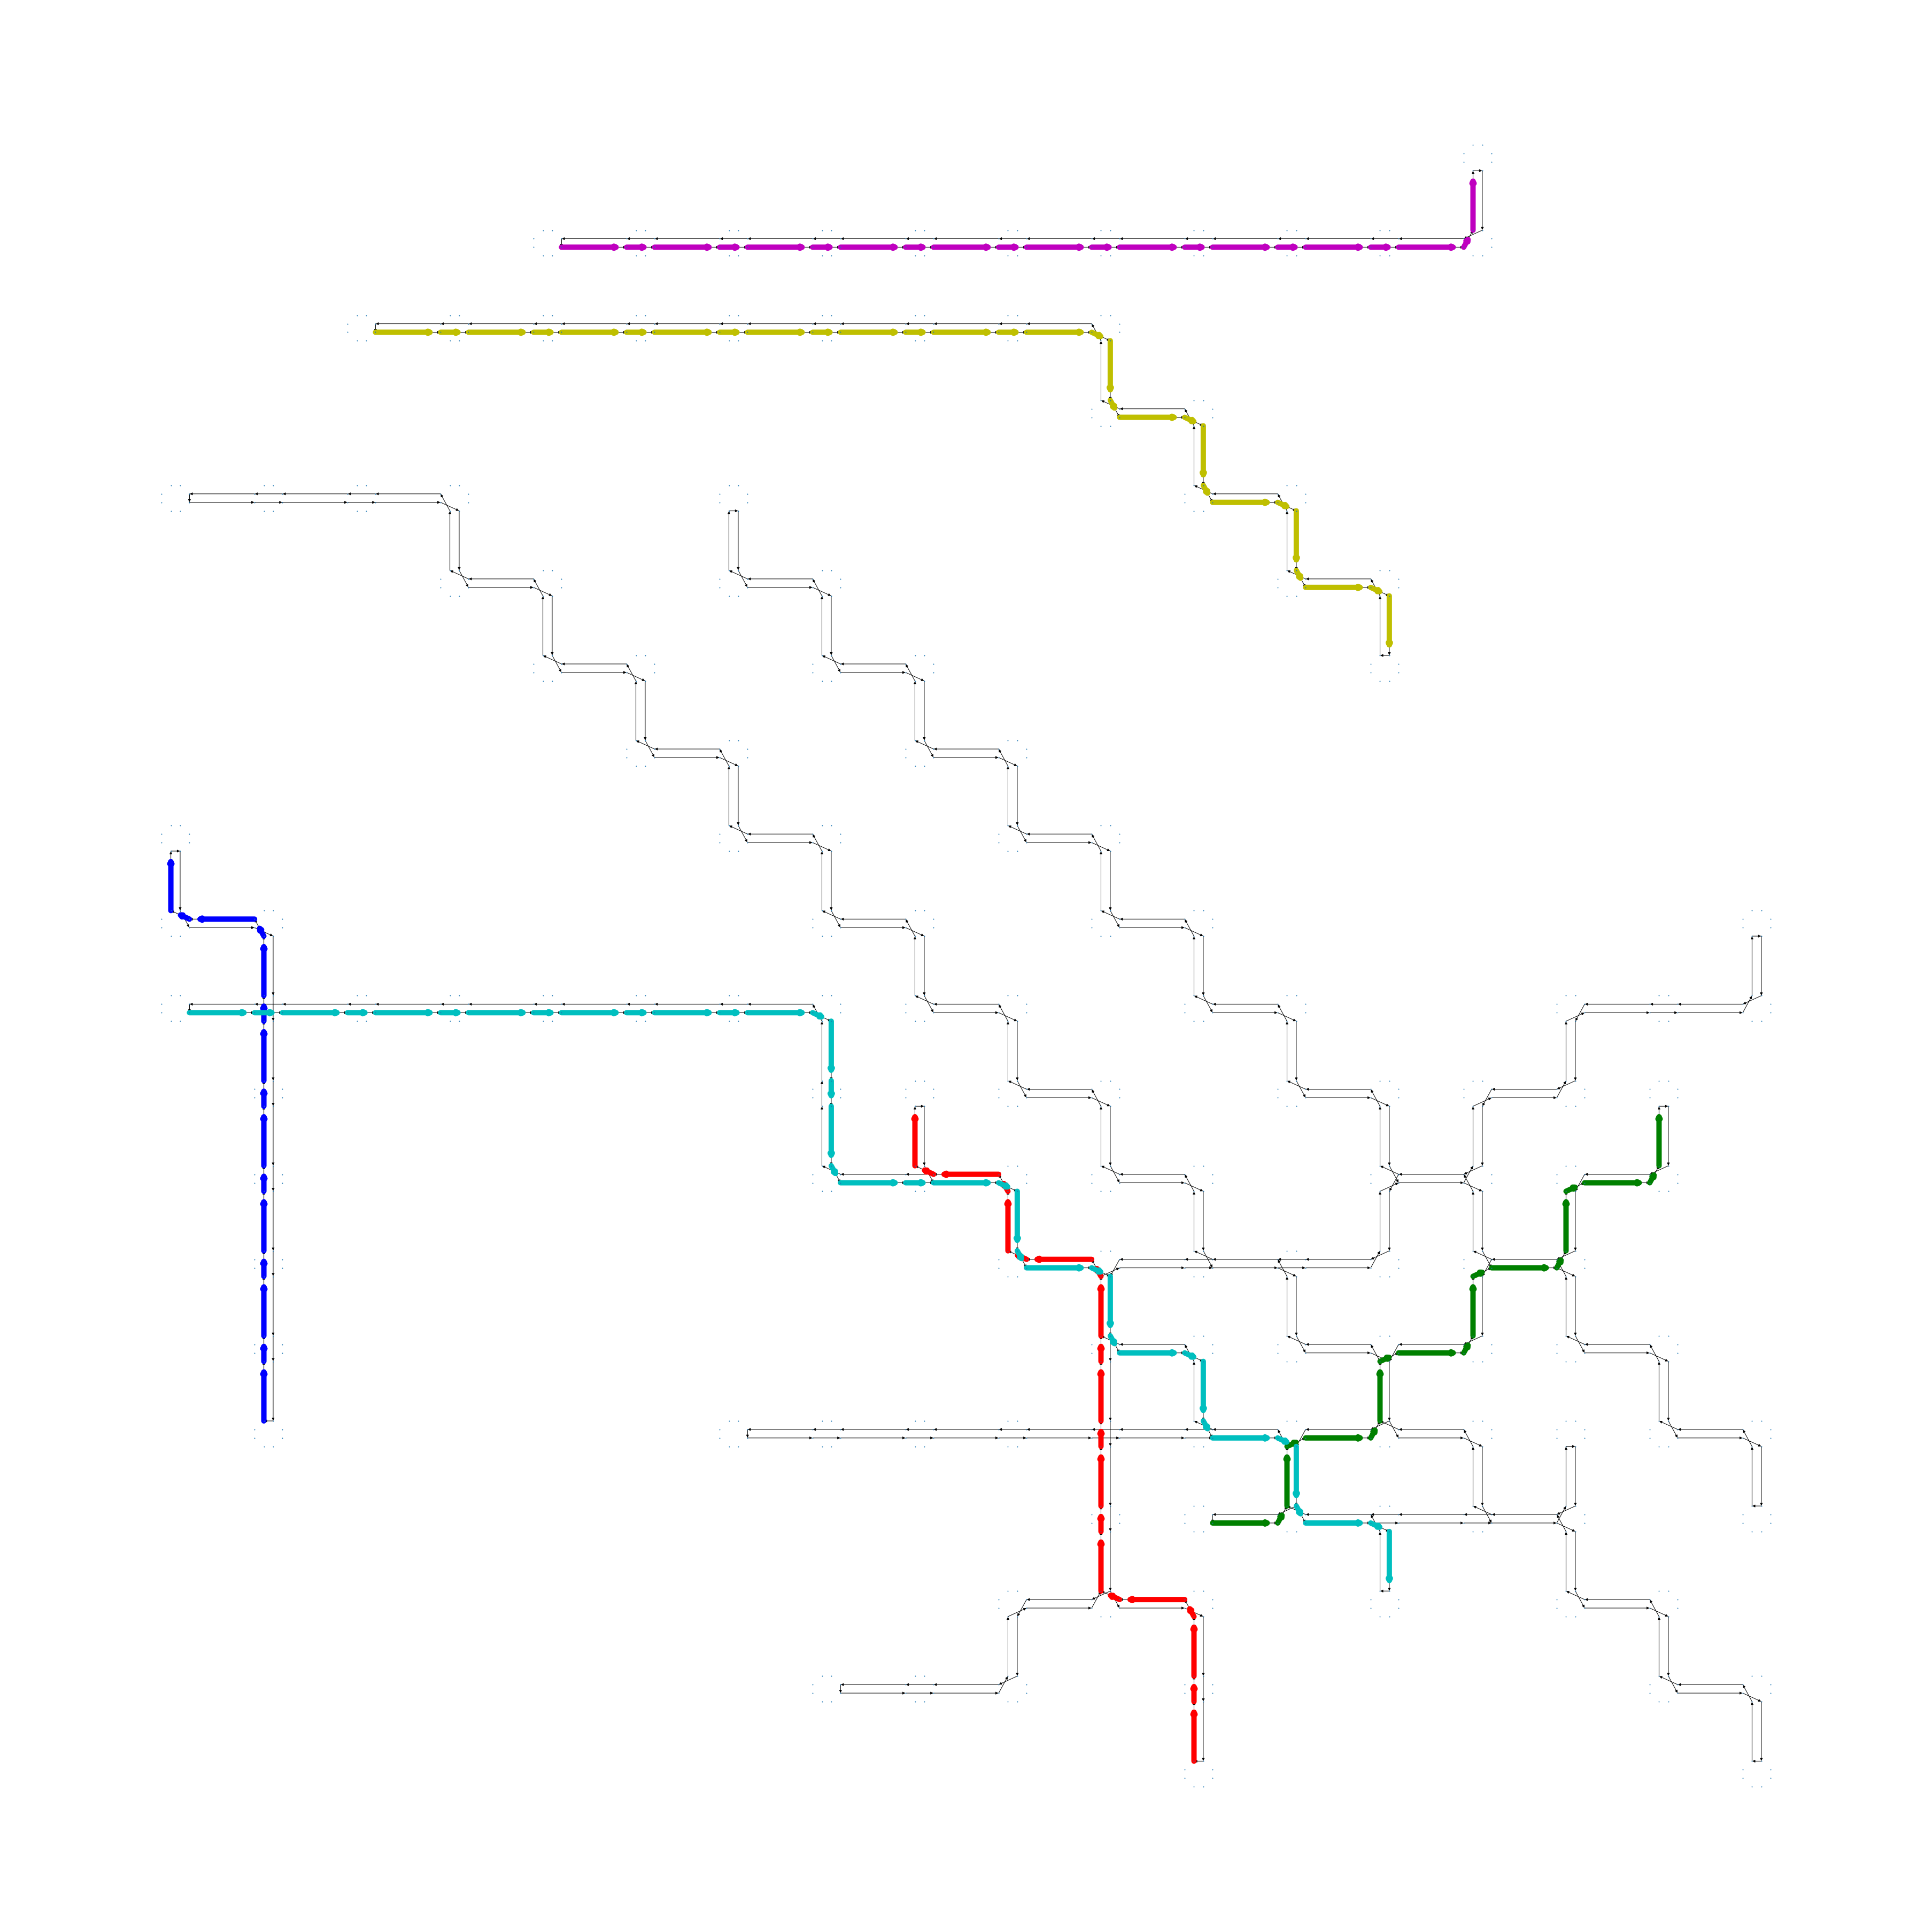

In [21]:
solver.transitionNetwork.show(paths = mcflow.solution_complete_edges)